In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
from matplotlib import pyplot as plt
from task.fancy import animate, animate_with_targets, plot_trace
import numpy as np
import torch
import time

# Learning

In [26]:
from task.dataset import generate_non_sequential_dataset, generate_randomstart_dataset, central_dataset
from task.square import static_evenly_spread_task, SegmentRun, proportional
from task.square import sense_all_sorted
controller = proportional

In [27]:
N = 4
number_of_samples = 10000
task = static_evenly_spread_task(N)
run = SegmentRun(task, controller=controller, sensor=sense_all_sorted(), dt=0.1)
train_dataset = central_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))
test_dataset = central_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))

## Centralized Network

In [28]:
from network import CentralizedNet, train_net
net = CentralizedNet(4)
training_loss, testing_loss = [], []
train_net(epochs=500, net=net, train_dataset=train_dataset, test_dataset=test_dataset, batch_size=100, 
          training_loss=training_loss, testing_loss=testing_loss);

100%|██████████| 500/500 [04:19<00:00,  1.93it/s]


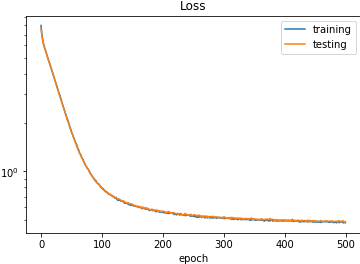

In [29]:
plt.title('Loss')
plt.semilogy(training_loss, label='training')
plt.semilogy(testing_loss, label='testing')
plt.xlabel('epoch')
plt.legend()
plt.savefig('centralized_train_loss')

In [30]:
from task import Run
from task.square import dynamic, sense_all_fixed
net_controller = net.controller()
net_run = Run(task, dynamic=dynamic(dt=0.1), sensor=sense_all_fixed(), dt=0.1, controller=net_controller)
#state = np.random.uniform(0, 1, size=(4, 2))
#net_controller(state, []), np.array(exact_controller(state, []))

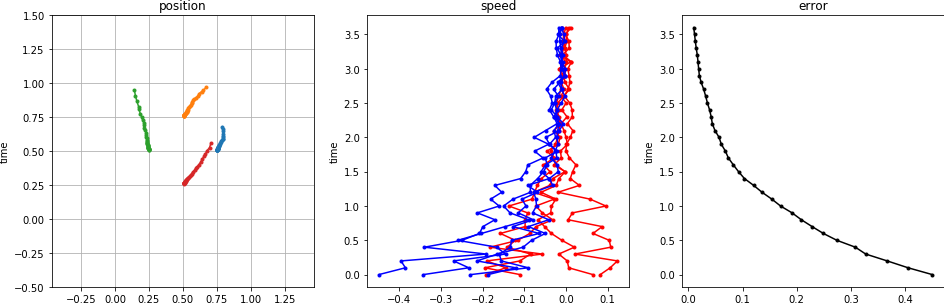

In [31]:
trace = net_run(T=4, epsilon=0.01)
plot_trace(trace)

In [35]:
animate_with_targets(trace, sensor=net_run.sensor, save_to='centralized_hungarian.mp4')

AxesSubplot(0.125,0.125;0.775x0.755)


### How well are we controlling the agents?

In [33]:
from task.dataset import generate_sequential_dataset
exact_traces = generate_sequential_dataset(run, number=100, duration=10, epsilon=0.01)
net_traces = generate_sequential_dataset(net_run, number=100, duration=10, epsilon=0.01)
from task import prepare
exact_traces = [prepare(t, padding=True, steps=50) for t in exact_traces]
net_traces = [prepare(t, padding=True, steps=50) for t in net_traces]
time = exact_traces[0].time
exact_error = np.array([t.error for t in exact_traces])
net_error = np.array([t.error for t in net_traces])

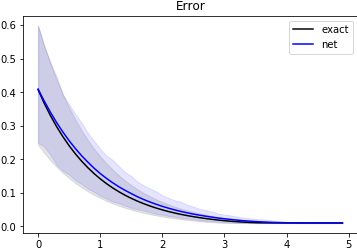

In [36]:
def plot_error(time, error, **kwargs):
    m = np.mean(error, axis=0)
    q95 = np.quantile(error, 0.95, axis=0)
    q5 = np.quantile(error, 0.05, axis=0)
    label = kwargs.pop('label', '')
    plt.plot(time, m, '-', label=label, **kwargs)
    plt.fill_between(time, q5, q95, alpha=0.1, **kwargs)
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plt.legend()
plt.savefig('centralized_hungarian_error_comp')
plt.title('Error');

## Distributed Network

In [106]:
from task.square import SegmentRun, smart_static_evenly_spread_task, dynamic_evenly_spread_task, sense_all_sorted
from task.dataset import distributed_dataset

In [107]:
N = 4
number_of_samples = 100000
EPS = 0.001
task = dynamic_evenly_spread_task(N)
#generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=0.00001)
run = SegmentRun(task, controller=controller, sensor=sense_all_sorted(), dt=0.1)
#d_train_dataset = distributed_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=EPS))
#d_test_dataset = distributed_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=EPS))
d_train_dataset = distributed_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))
d_test_dataset = distributed_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))

In [108]:
from network import DistributedNet
d_net = DistributedNet(run.sensor.get_input_size(N))
d_training_loss, d_testing_loss = [], []
train_net(epochs=500, net=d_net, train_dataset=d_train_dataset, test_dataset=d_test_dataset, batch_size=100, 
          training_loss=d_training_loss, testing_loss=d_testing_loss);

  2%|▏         | 10/500 [02:44<2:14:39, 16.49s/it]

KeyboardInterrupt: 

In [ ]:
d_net_controller = d_net.controller()
d_net_run = Run(task, dynamic=dynamic(dt=0.1), sensor=sense_all_fixed(), dt=0.1, controller=d_net_controller)
trace = d_net_run(T=25, epsilon=0.01)
plot_trace(trace)
animate(trace, dt=0.01)

In [ ]:
animate_with_targets(trace, sensor=net_run.sensor)

In [ ]:
d_net_traces = generate_sequential_dataset(d_net_run, number=1000, duration=10, epsilon=0.01)
d_net_traces = [prepare(t, padding=True, steps=50) for t in d_net_traces]
d_net_error = np.array([t.error for t in d_net_traces])

In [ ]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plt.legend()
plt.title('Error');

## Distributed Communicating Network

In [85]:
from task.dataset import sequence_dataset
from task.square import smart_static_evenly_spread_task, sense_fixed_in_range, SegmentRun, proportional, static_zipf_task

In [86]:
number_of_samples = 100
run = SegmentRun(smart_static_evenly_spread_task(4), controller=controller, sensor=sense_fixed_in_range(), dt=0.1)
train_traces = generate_sequential_dataset(run=run, number=number_of_samples)
test_traces = generate_sequential_dataset(run=run, number=number_of_samples)

In [87]:
train_traces[0]

Trace(time=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1]), state=array([[[ 3.20735798e-01,  8.08084264e-01],
        [ 3.98667854e-01,  2.18820060e-01],
        [ 2.39359859e-01,  4.36281040e-04],
        [ 8.80620743e-01,  7.87654805e-01]],

       [[ 3.16968029e-01,  8.19421014e-01],
        [ 4.22464471e-01,  1.95542648e-01],
        [ 2.14638188e-01,  2.80887423e-02],
        [ 8.85313566e-01,  7.71943006e-01]],

       [[ 3.13577036e-01,  8.29624090e-01],
        [ 4.43881426e-01,  1.74592976e-01],
        [ 1.92388684e-01,  5.29759575e-02],
        [ 8.89537108e-01,  7.57802387e-01]],

       [[ 3.10525143e-01,  8.38806858e-01],
        [ 4.63156686e-01,  1.55738272e-01],
        [ 1.72364130e-01,  7.53744511e-02],
        [ 8.93338295e-01,  7.45075829e-01]],

       [[ 3.07778439e-01,  8.47071349e-01],
        [ 4.80504419e-01,  1.38769039e-01],


In [88]:
c_train_dataset = sequence_dataset(train_traces, steps=3)
c_test_dataset = sequence_dataset(test_traces, steps=3)
c_train_dataset[50]

(tensor([[[[-0.0408,  0.2206,  1.0000],
           [ 0.6210, -0.2266,  1.0000],
           [-0.3001, -0.4397,  1.0000]],
 
          [[ 0.0408,  0.4494,  1.0000],
           [ 0.6618, -0.0385,  1.0000],
           [-0.1120, -0.2517,  1.0000]],
 
          [[-0.6210, -0.2124,  1.0000],
           [-0.6618,  0.0385,  1.0000],
           [-0.0735, -0.2132,  1.0000]],
 
          [[-0.1086,  0.3001,  1.0000],
           [-0.1494,  0.2517,  1.0000],
           [ 0.6521,  0.2132,  1.0000]]],
 
 
         [[[-0.0909,  0.2008,  1.0000],
           [ 0.6043, -0.2581,  1.0000],
           [-0.3266, -0.4954,  1.0000]],
 
          [[ 0.0909,  0.5064,  1.0000],
           [ 0.6953, -0.0435,  1.0000],
           [-0.1119, -0.2807,  1.0000]],
 
          [[-0.6043, -0.1889,  1.0000],
           [-0.6953,  0.0435,  1.0000],
           [-0.0684, -0.2372,  1.0000]],
 
          [[-0.0889,  0.3266,  1.0000],
           [-0.1798,  0.2807,  1.0000],
           [ 0.6843,  0.2372,  1.0000]]],
 
 
         [

In [89]:
from com_network import ComNet

In [90]:
c_net = ComNet(N=N, broadcast=2)
c_training_loss, c_testing_loss = [], []

In [91]:
train_net(epochs=100, net=c_net, train_dataset=c_train_dataset, test_dataset=c_test_dataset, batch_size=100, 
          training_loss=c_training_loss, testing_loss=c_testing_loss);

100%|██████████| 100/100 [01:54<00:00,  1.13s/it]


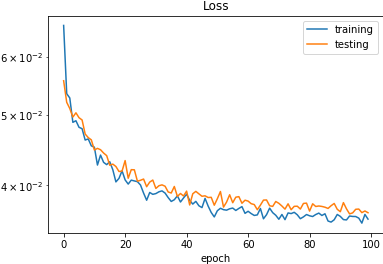

In [92]:
plt.title('Loss')
plt.semilogy(c_training_loss, label='training')
plt.semilogy(c_testing_loss, label='testing')
plt.xlabel('epoch')
plt.legend()

In [93]:
c_net_controller = c_net.controller()
c_net_run = Run(task, dynamic=dynamic(dt=0.1), sensor=sense_fixed_in_range(), dt=0.1, controller=c_net_controller)

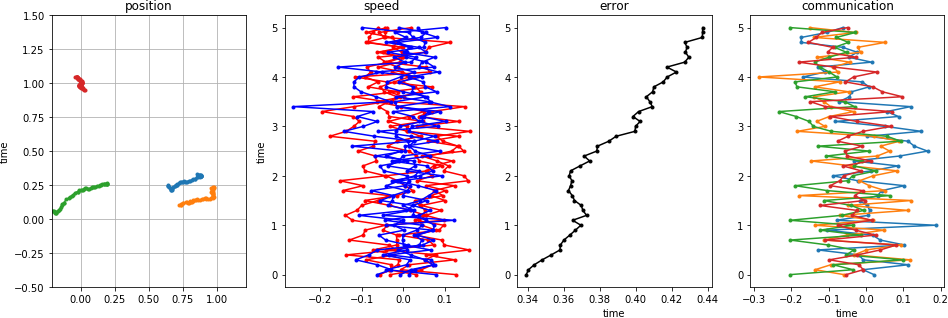

In [97]:
trace = c_net_run(T=5)
plot_trace(trace)

In [99]:
animate_with_targets(trace, sensor=net_run.sensor)

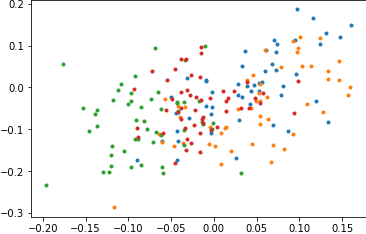

In [105]:
plt.plot(trace.control[:,:,0], trace.communication[:,0,:], '.')

In [101]:
c_net_traces = generate_sequential_dataset(c_net_run, number=1000, duration=5, epsilon=0.01)

In [102]:
c_net_traces = [prepare(t, padding=True, steps=50) for t in c_net_traces]

In [103]:
c_net_error = np.array([t.error for t in c_net_traces])

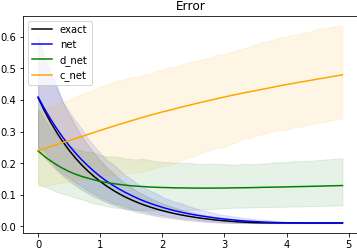

In [104]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plot_error(time, c_net_error, color='orange', label='c_net')
plt.legend()
plt.title('Error');